In [1]:
import os
import pickle
import warnings

import altair as alt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from omegaconf import OmegaConf

from retailsynth import REPO_ROOT_DIR
from retailsynth.base_config import load_config_store
from retailsynth.datasets.complete_journey.preprocess_pipeline import run_preprocess
from retailsynth.utils.storage import clear_cwd
from retailsynth.utils.dataset_viz import viz_main
from retailsynth.utils.storage import load_result
from calib_utils.plot_discounts import (
    plot_discount_series,
    prepare_discount_df,
    plot_status_transition,
)
from calib_utils.plot_elasticity import (
    list_elasticity_one_step_kdeplot,
    list_elasticity_one_step_heatmap,
    initialize_elasticity_viz_data_layer,
)
from calib_utils.plot_purchases import (
    Plotter,
)
from calib_utils.plot_utils import (
    make_plot_data,
    make_exploratory_plot,
    plot_price_history,
)

alt.renderers.enable("png")
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload
%autoreload 2

/Users/64313/Documents/repos/retailsynth/src/retailsynth/utils/dataset_viz.py:102: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(
/Users/64313/Documents/repos/retailsynth/src/retailsynth/utils/dataset_viz.py:111: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(


# Introduction
This notebook includes the collection of data analysis steps used to calibrate and validate the RetailSynth data synthesizer. While developing Retailsynth, we tuned model hyperparameters manually leveraging this notebook for feedback and also used it to validate the results of fine-tuning, performed with Bayesian hyperparameter optimization as implemented in `analysis_workflow/2_synthesizer_calibration/2_parameter_sweeping.py.` 

## Model Overview
RetailSynth is based on an interpretable multi-stage model that captures the sequential nature of customer decision-making. In this model, the consumer needs to make a collection of decisions, from whether to visit the retail store, which category of products to purchase, which product from the selected category to purchase, to how many units of selected products to purchase. Each step can only be triggered if the answer to the prior step is positive. Thus, the environment captures that, for a customer $u$, product $i$, category $j$ individual demand is calculated using the following conditional probability distribution:

$$
P(Q_{ui} = q,S_u,C_{uj},B_{ui}) = 
$$

$$
\text{StoreVisit} * \text{CategoryChoice} * \text{ProductChoice} * \text{ProductDemand}
$$

$$
=P(S_u) * P(C_{uj} | S_u) * P(B_{ui}|S_u,C_{uj}) * P(Q_{ui}=q|S_u,C_{uj},B_{ui})
$$

The model is intended to capture both short-term purchase behavior and long-term customer loyalty. _For a detailed formulation of the model at each step, please refer to the paper._

## Calibration and Validation Process
To calibrate the synthesizer, we set up a simulation of 100 customers over a period of 53 weeks utilizing a product catalog that mirrors the Complete Journey dataset, encompassing approximately ∼26,000 products across 300 categories. Within this notebook, we compare a collection of probability distributions and key metrics generated by the data synthesizer against real-world data.

### Processing Pipeline 

To ensure reproducibility, we re-run the synthetic data generation and feature engineering workflows in this notebook. The driver function is called `viz_main` and can execute the end-to-end pipeline. The steps include:

- Generation of synthetic transactions and pricing histories, or loading real-world data.
- Feature engineering at store, category, and product levels from transaction data.
- Saving engineered features.


#### Run feature engineering on Complete Journey dataset

In [2]:
output_path = REPO_ROOT_DIR / "analysis_workflow/2_synthesizer_calibration/outputs"
output_path.mkdir(parents=True, exist_ok=True)
os.chdir(output_path)
os.getcwd()

with initialize(version_base=None, config_path="cfg"):
    load_config_store()
    cfg = compose(config_name="real_dataset")
    clear_cwd(cfg.paths.processed_data)
    viz_main(cfg)
    REAL_DATA_PATH = cfg.paths.processed_data

#### Generate synthetic data

In [3]:
with initialize(version_base=None, config_path="cfg"):
    load_config_store()
    cfg = compose(config_name="synthetic_dataset")
    clear_cwd(cfg.paths.processed_data)
    viz_main(cfg)
    SYNTHETIC_DATA_PATH = cfg.paths.processed_data

Synthesizing trajectory: 100%|██████████| 53/53 [03:19<00:00,  3.77s/it]


#### Load results

In [4]:
complete_journey_result = load_result(output_path / REAL_DATA_PATH)
synthetic_result = load_result(output_path / SYNTHETIC_DATA_PATH)
with open(output_path / SYNTHETIC_DATA_PATH / "synthesizer.pickle", "rb") as fp:
    synthesizer = pickle.load(fp)

# run pre-process scripts to load the datasets
with initialize(version_base=None, config_path="cfg"):
    load_config_store()
    cfg = compose(config_name="real_dataset", overrides=["n_customers_sampled=null"])
    cfg = OmegaConf.to_object(cfg)
    customers, products, transactions = run_preprocess(cfg)

weekly_aggregates = make_plot_data(transactions, products)

category_catalog = (
    products[
        [
            "manufacturer_id",
            "department",
            "brand",
            "category_desc",
            "subcategory_desc",
            "package_size",
            "all",
            "category_nbr",
        ]
    ]
    .drop_duplicates("category_nbr")
    .set_index("category_nbr")
)

In [5]:
results = [complete_journey_result, synthetic_result]
labels = ["real_data", "synthetic_data"]
colors = sns.color_palette(n_colors=len(results))

plotter = Plotter(
    results=[complete_journey_result, synthetic_result],
    labels=["real_data", "synthetic_data"],
    row_size=20,
)

### Demand analysis

Since we are using the Complete Journey data for calibration, we want to understand the extent of price variation and its effect on demand in the dataset. The data is quite noisy in aggregate, so we simplify our analysis by looking at specific products within a sub-category with high sales volume and pricing variability. Let us take a look at the `economy` subcategory of the `bacon` category. 

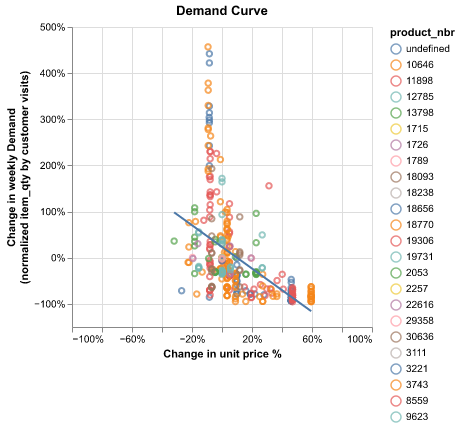

In [6]:
CATEGORY_OF_INTEREST = "bacon"  # 'fluid milk products'
SUBCATEGORY_OF_INTEREST = "economy"  # 'fluid milk white only'
POLYNOMIAL_DEGREE = 1
make_exploratory_plot(
    weekly_aggregates,
    category=CATEGORY_OF_INTEREST,
    subcategory=SUBCATEGORY_OF_INTEREST,
    plot_poly_order=POLYNOMIAL_DEGREE,
)

Our analysis confirms a classic demand response to pricing - demand decreases with increasing prices. However, we only capture a partial view as extreme discount data is absent (likely due to the retailer safeguarding their profit margins). Similar trends in other categories verify this pattern. We expect that calibrating the synthesizer to match this dataset will produce a meaningful demand curve. (We verify this in the scenario analysis.)

# Pricing Data Analysis
Typical retail datasets, like the Complete Journey dataset, do not include a complete price history for all products, as they are produced by legacy systems that log only transactions. We need to understand the pricing policies used in this dataset and then implement a synthetic analog in the syntheizer.  

### Price Histories in Complete Journey Dataset

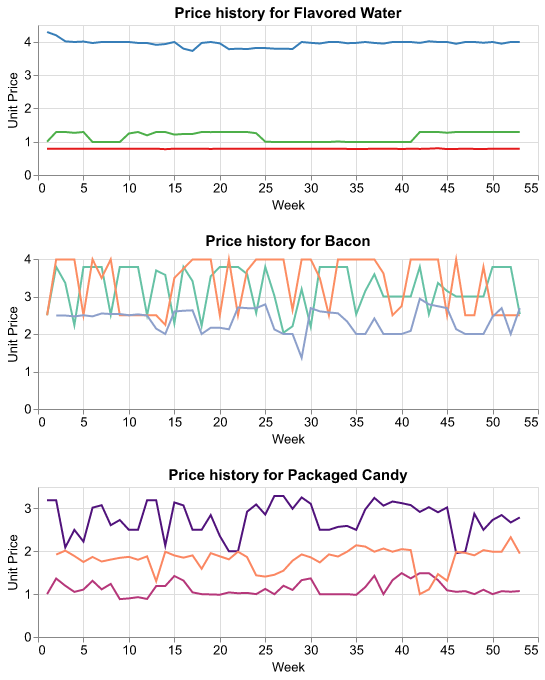

In [7]:
water_plot = plot_price_history(
    weekly_aggregates,
    product_list=["3208", "12642", "3210"],
    category="Flavored Water",
    color_scheme="set1",
)
bacon_plot = plot_price_history(
    weekly_aggregates,
    product_list=["1020", "10308", "2567"],
    category="Bacon",
    color_scheme="set2",
)
candy_plot = plot_price_history(
    weekly_aggregates,
    product_list=["1390", "23269", "2760"],
    category="Packaged Candy",
    color_scheme="magma",
)

fig = (
    alt.vconcat(water_plot, bacon_plot, candy_plot)
    .resolve_scale(color="independent")
    .configure_legend(disable=True)
    .configure_axis(labelFontSize=13, titleFontSize=13, titleFontWeight="normal")
    .configure_title(fontSize=15, fontWeight="bold")
)
fig.save("price_history_real_data.png")
fig

Chronological pricing analysis of a few product categories highlights deliberate, non-random price-setting policies. The baseline pricing strategy appears to follow a high-low pattern, with distinct discount frequencies and depths across product types.

# Synthesizer Pricing Policy Analysis

As described in the paper, our synthesizer uses a stochastic pricing policy, based on a Hidden Markov Model. Within the synthetic dataset, we compare the price history for a product with frequent discounts and one with few discounts to ensure the model is producing diverse pricing policies for different products.

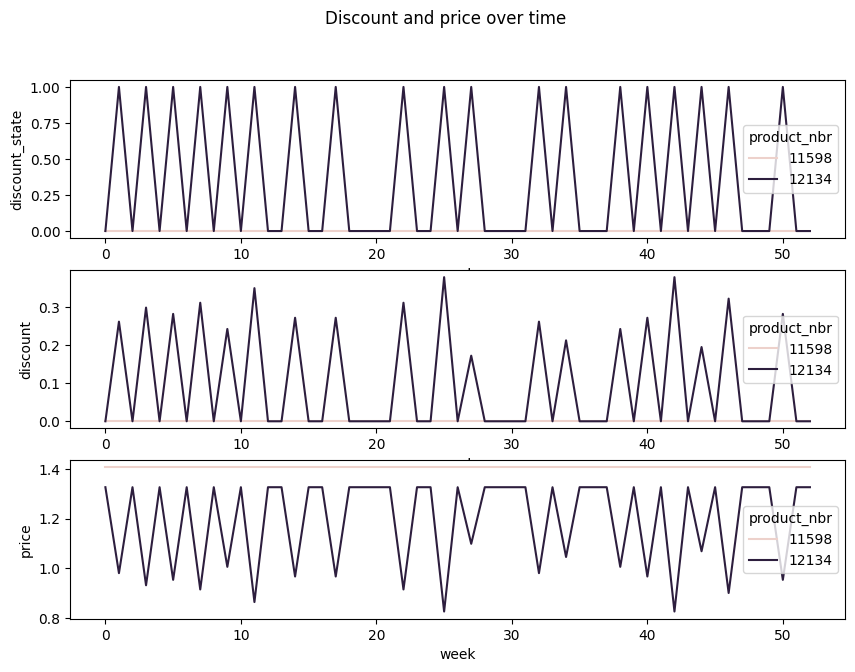

In [8]:
transition_prob = synthesizer.transition_prob.mean
diff = transition_prob[:, 0] - transition_prob[:, 1]
no_discount_product = int(diff.argmin())
always_discount_product = int(diff.argmax())
p_index = [no_discount_product, always_discount_product]

select_product_price_df = prepare_discount_df(synthesizer, p_index)
ax = plot_discount_series(select_product_price_df)

We see that these products reflect very different discounting regimes, as expected. Next, we look to understand the aggregate effects of the pricing policies.

The graph below shows the percentage of discount state and no-discount state across products, each week. We can see that about 80% of products are offered at the original price and 20% of products are on sale each week in the synthetic dataset.

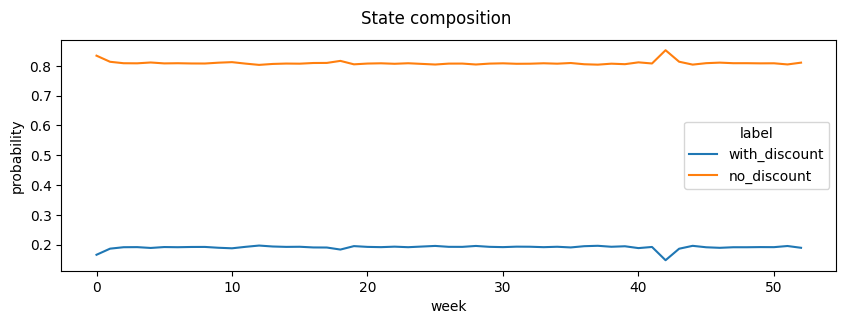

In [9]:
discount_state = jnp.array(synthesizer.choice_decision_stats["discount_state"])
axes = plot_status_transition(discount_state, n_product=-1)

# Comparison of Synthetic and Complete Journey Datasets
We compare here the distributions for the synthetic and Complete Journey datasets that describe the product catalog, customer purchase decisions, and aggregate business metrics.  

## Product Price and Category Size Distributions

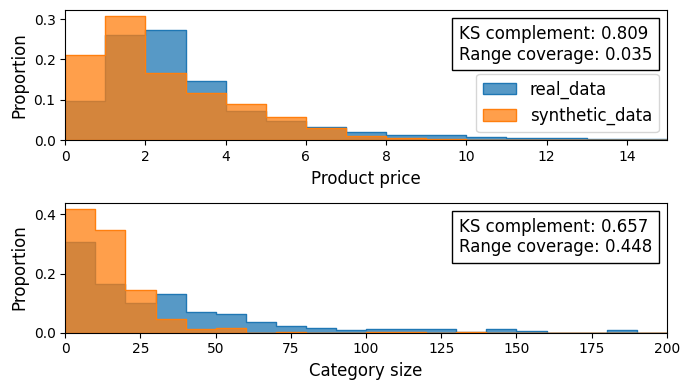

In [10]:
plotting_dirs = [
    (
        plotter.plot_product_price_variation,
        dict(binwidth=1, xlim_min=0, xlim_max=15, legend=True),
    ),
    (
        plotter.plot_product_counts_per_category,
        dict(binwidth=10, xlim_min=0, xlim_max=200),
    ),
]
fig, axes = plotter.examine_datasets(
    plotting_dirs,
    row_size=7,
    label_args={"fontsize": 12},
    legend_args={"fontsize": 12, "loc": "lower right"},
    text_args={"fontsize": 12},
    text_loc="upper right",
)
fig.savefig("synthetic_price_distribution.png")

## Choice Probability Distributions

We calibrated the synthesizer to generate customer dynamic similar to the Complete Journey dataset. Here, we visualize the shape of choice probability distribution for each step. Our objective is to determine if our synthesizer is able to replicate the shape of the distributions, which tend to be heavy-tailed.

Throughout this section, we leverage the KS complement and Range coverage metrics to assess the goodness-of-fit. For both, scores of 1 are the best and 0 the worst. We limit our discussion of the implications of these fit metrics here and refer the interested reader to the paper.

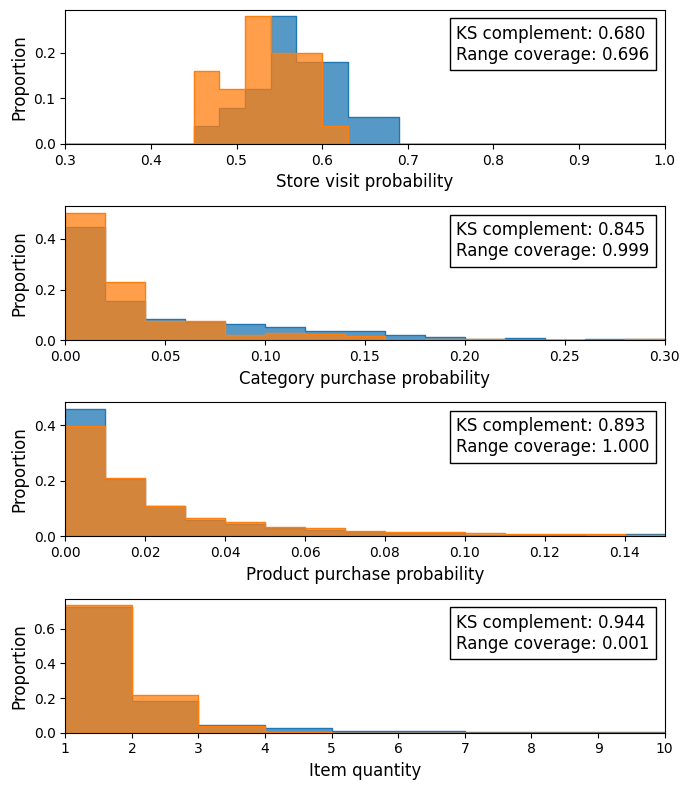

In [11]:
ACQ_WEEK_THR = 3  # Threshold for when customers must be acquired by to look at time since last purchase.

plotting_dirs = [
    (
        plotter.plot_customer_visits,
        dict(
            binwidth=0.03, xlim_min=0.3, xlim_max=1, acq_week=ACQ_WEEK_THR, legend=False
        ),
    ),
    (
        plotter.plot_category_purchase_freq_by_hierarchy,
        dict(binwidth=0.02, xlim_min=0, xlim_max=0.3),
    ),
    (
        plotter.plot_product_purchase_freq_by_hierarchy,
        dict(binwidth=0.01, xlim_min=0, xlim_max=0.15),
    ),
    (plotter.plot_individual_demand, dict(binwidth=1, xlim_min=1, xlim_max=10)),
]
fig, axes = plotter.examine_datasets(
    plotting_dirs,
    row_size=7,
    label_args={"fontsize": 12},
    legend_args={"fontsize": 12},
    text_args={"fontsize": 12},
    text_loc="upper right",
)
fig.savefig("outcome_distribution_fit.png")

## Key Metrics

The following distributions show key aggregate business metrics describing customer loyalty, category penetration, basket size, and sales volume.

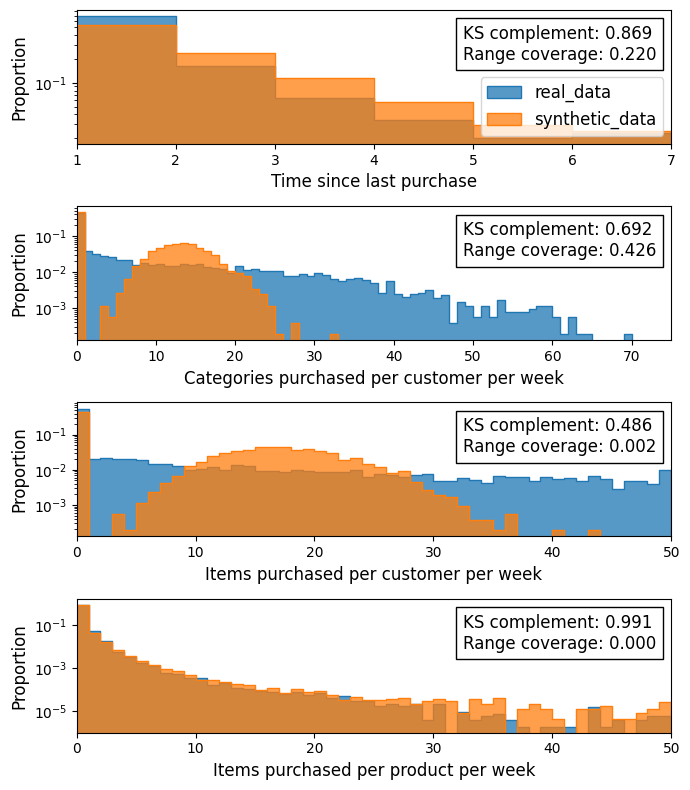

In [12]:
plotting_dirs = [
    (
        plotter.plot_time_since_last_purchase,
        dict(binwidth=1, xlim_min=1, xlim_max=7, legend=True),
    ),
    (
        plotter.plot_basket_size_category_count,
        dict(binwidth=1, xlim_min=0, xlim_max=75),
    ),
    (plotter.plot_basket_size, dict(binwidth=1, xlim_min=0, xlim_max=50)),
    (plotter.plot_product_sales, dict(binwidth=1, xlim_min=0, xlim_max=50)),
]
fig, axes = plotter.examine_datasets(
    plotting_dirs,
    row_size=7,
    label_args={"fontsize": 12},
    legend_args={"fontsize": 12, "loc": "lower right"},
    text_args={"fontsize": 12},
    text_loc="upper right",
)
fig.savefig("key_metric_distribution_fit.png")

# Price Elasticity Analysis
## Price Elasticities across Products and Customers

Our multi-stage framework allows us to derive price elasticity of one product at different levels defined in a
closed-form manner. While simulating the customer trajectories, RetailSynth stores the price elasticity for each step internally in the
container `elasticity_stats`. We implement a `DataLayer` object to convert the elasticity array to a more readable
representation in the data frame format. _The analytic elasticity formulas are provided in the appendix of the paper._

In [13]:
dl = initialize_elasticity_viz_data_layer(synthesizer)

The heatmap below visualizes the mean elasticity value for each customer and each product. The color of the heatmap
represents the elasticity value, the x-axis represents the customer id and the y-axis is the product id. This graph
shows that our synthesizer is able to provide varied price response across products and across customers.

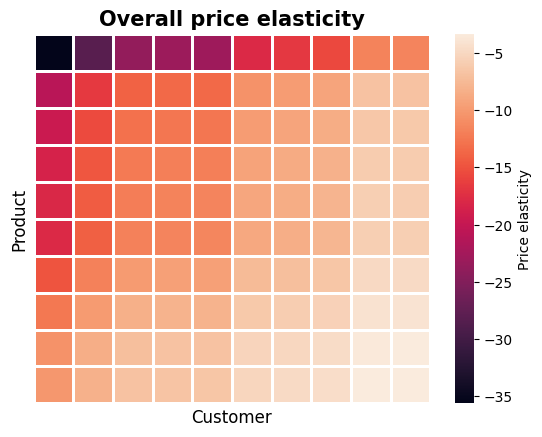

In [14]:
n_customer = 10
n_product = 10
category_nbr = 2
customer_product_elasticity = dl.get_elasticity_per_customer_per_product()
customer_key = customer_product_elasticity.customer_key.unique()[:n_customer]
product_nbr = customer_product_elasticity.query(
    f"category_nbr == {category_nbr}"
).product_nbr.unique()[:n_product]

ax = list_elasticity_one_step_heatmap(
    customer_product_elasticity,
    "overall_elasticity",
    "Overall elasticity",
    category_nbr=category_nbr,
    customer_list=customer_key,
    product_list=product_nbr,
)
ax.set_title("Overall price elasticity", fontsize=15, fontweight="bold")
ax.set_xlabel("Customer", fontsize=12)
ax.set_ylabel("Product", fontsize=12)
ax.get_figure().savefig("elasticity_heatmap.png")

## Consumer-Specific Elasticity 


In [15]:
PRODUCT_IDX = 0
n_customer = -1
plot_elasticity_df = dl.get_elasticity_per_week_per_customer_per_product(PRODUCT_IDX)
customer_list = plot_elasticity_df.customer_key.unique()[:n_customer]

We generate contour plots for price elasticity of product. Each observation of elasticity is from one customer at one
time step and the color of the contour plot represents different probability densities.

/Users/64313/Documents/repos/retailsynth/analysis_workflow/2_synthesizer_calibration/calib_utils/plot_elasticity.py:286: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.kdeplot(


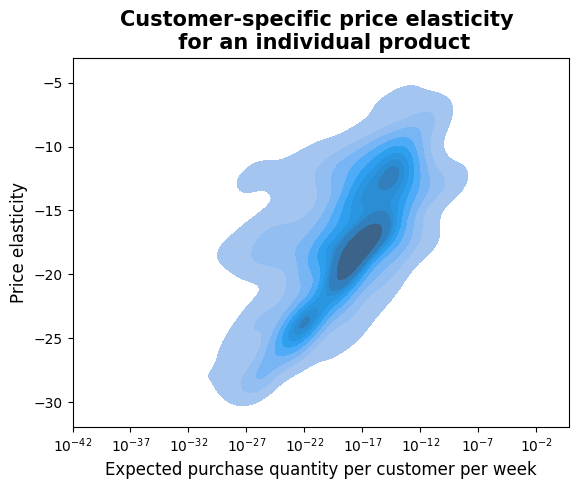

In [16]:
ax = list_elasticity_one_step_kdeplot(
    plot_elasticity_df,
    "expected_demand",
    "overall_elasticity",
    xlabel="Expected purchase quantity per customer per week",
    ylabel="Price elasticity of demand",
    color=sns.color_palette("rocket", as_cmap=True),
    customer_key=customer_list,
    legend_loc="lower right",
    ylim_bottom=None,
    ylim_top=None,
    xlim_left=1e-42,
    xlim_right=None,
    log_scale=(True, False),
)
ax.set_title(
    "Customer-specific price elasticity \n for an individual product",
    fontsize=15,
    fontweight="bold",
)
ax.set_xlabel("Expected purchase quantity per customer per week", fontsize=12)
ax.set_ylabel("Price elasticity", fontsize=12)
ax.get_figure().savefig("elasticity_kde.png")

# Appendix: Category Choice Analysis

One of the key assumptions we make in our modeling framework is that each category is chosen independently. This assumption gives rise to basket sizes following a relatively narrow distribution, as opposed to a heavy-tailed distribution resulting from a more complex choice process that we observe in the Complete Journey dataset. 

We perform market basket analysis at the category level to see if there is a significant
affinity for categories to be purchased together using the Apriori algorithm, a popular method used in data mining for
extracting such association rules. 

Key concepts crucial to understanding the Apriori algorithm's workings include Support, Confidence, and Lift. Each of
these measures provides different insights into the strength and reliability of discovered associations.

**Support** is an indication of how frequently a category set appears in the dataset. Mathematically, it can be denoted
as:

$$ Support(X) = \frac{Freq(X)}{N} $$

where $Freq(X)$ is the number of transactions where category X appears, and $N$ is the total number of transactions. We
can also call it category choice probability.

**Confidence** is a measure of the probability that category Y is purchased given category X is purchased. It is
expressed as:

$$ Confidence(X \rightarrow Y) = \frac{Support(X, Y)}{Support(X)} $$

where $Support(X, Y)$ is the probability of the category set containing both X and Y. Confidence is equal to the conditional
probability $P(X|Y)$.

**Lift** indicates the strength of a rule over the random occurrence of X and Y. It is a measure of the likelihood that
category Y is bought when category X is bought while considering the popularity of Y.

- If Lift is much larger than 1, it means that category Y is likely to be bought if category X is bought.
- If Lift is small and the support of X is big, it means that category Y is unlikely to be bought if category X is
  bought.

Mathematically, it can be represented as:

$$ Lift(X \rightarrow Y) = \frac{Confidence(X \rightarrow Y)}{Support(Y)} $$

## Category choice in Complete Journey Dataset
Let's extract product association metrics from the real datase for each tuple of categories of length two.

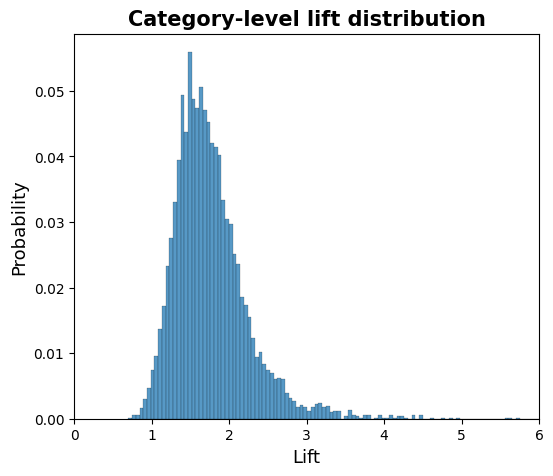

In [17]:
# Prepare one-hot-encoding vector for each basket
real_category_choice = complete_journey_result["category_choice"].reset_index()[
    ["category_nbr", "week", "customer_key", "category_choice"]
]
real_category_choice = real_category_choice.query("category_choice == 1")
real_category_choice = real_category_choice.groupby(["week", "customer_key"])[
    "category_nbr"
].apply(list)
encoder = TransactionEncoder()
te_ary = encoder.fit(real_category_choice).transform(real_category_choice)
df = pd.DataFrame(te_ary, columns=encoder.columns_)

# Building the model
frq_items = apriori(df, min_support=0.01, max_len=2, use_colnames=True)

# Collecting the inferred rules in a dataframe
real_rules = association_rules(frq_items, metric="lift", min_threshold=0)

# Plot the category lift distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax = sns.histplot(real_rules.lift, stat="probability")
ax.set_title("Category-level lift distribution", weight="bold", fontsize=15)
ax.set_xlabel("Lift", fontsize=13)
ax.set_ylabel("Probability", fontsize=13)
ax.set_xlim(0, 6)
fig.savefig("category_apriori_real_data.png")

The lift values for The Complete Journey dataset are centered around 1.7, with values raning from ~0.7 to 12, implying that many category choices in the dataset are not independent.

Let's take a closer look at category pairs with lift values smaller than 0.8, where the products are substitutable.

In [18]:
real_rules.loc[:, "support_sum"] = (
    real_rules.loc[:, "consequent support"] + real_rules.loc[:, "antecedent support"]
)
real_rules.query("lift < 0.8").sort_values(
    ["support_sum", "lift"], ascending=[False, False]
).head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,support_sum
10128,(112),(110),0.230196,0.119838,0.021327,0.092647,0.773106,-0.006259,0.970033,-0.276016,0.350034
10129,(110),(112),0.119838,0.230196,0.021327,0.177966,0.773106,-0.006259,0.936462,-0.250062,0.350034
10179,(110),(208),0.119838,0.224103,0.020311,0.169492,0.756311,-0.006544,0.934243,-0.267977,0.343940


In [19]:
select_category_idx = [112, 110]
category_catalog.loc[select_category_idx]

,manufacturer_id,department,brand,category_desc,subcategory_desc,package_size,all
category_nbr,,,,,,,
112,69,grocery,private,refrgratd juices/drnks,dairy case 100% pure juice - o,1 ga,all
110,239,grocery,national,beers/ales,beeralemalt liquors,12 oz,all


Taking the first tuple of categories above, it shows that a customer has less tendency to buy juice and beer at the same
time. This seems like a very plausible set of substitutable products since both are beverages.

In addition, there appear to be many complementary categories in the Complete Journey dataset. We look at a some category pairs with higher lift values.

In [20]:
real_rules.query("lift > 3").sort_values(
    ["support_sum", "lift"], ascending=[True, True]
).head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,support_sum
6999,(51),(217),0.030806,0.036561,0.014218,0.461538,12.623932,0.013092,1.789245,0.950052,0.067366
6998,(217),(51),0.036561,0.030806,0.014218,0.388889,12.623932,0.013092,1.585954,0.955727,0.067366
10468,(116),(221),0.064658,0.027759,0.011848,0.183246,6.601328,0.010053,1.190372,0.907171,0.092417


In [21]:
select_category_idx = [116, 221]
category_catalog.loc[select_category_idx]

,manufacturer_id,department,brand,category_desc,subcategory_desc,package_size,all
category_nbr,,,,,,,
116,69,grocery,private,dog foods,dry dog value (pet pride/klr/g,22 lb,all
221,1016,grocery,national,pet care supplies,dog & cat accessories,None,all


The example reflects a pattern where complementary pet products are commonly purchased at the same time. Again, this seems like a real effect and very unlikely to just be a statistical artifact. To understand the significance of the many large lift values observed in the distribution, we perform the same analysis on the synthetic datataset and compare the results.


## Category Choice in Synthetic Dataset

Text(0.5, 0, 'Lift')

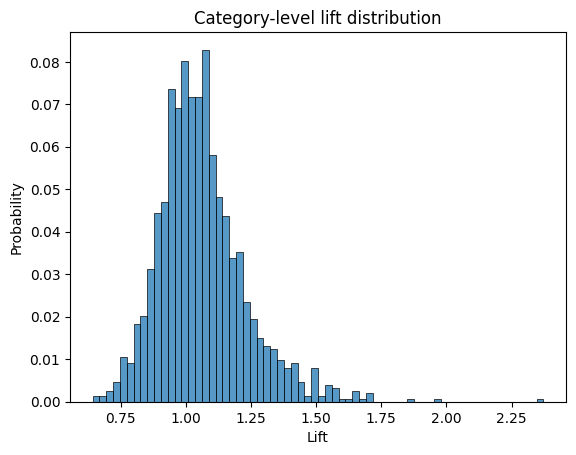

In [22]:
# Prepare one-hot-encoding vector for each basket
synthetic_category_choice = synthetic_result["category_choice"].reset_index()[
    ["category_nbr", "week", "customer_key", "category_choice"]
]
synthetic_category_choice = synthetic_category_choice.query("category_choice == 1")
synthetic_category_choice = synthetic_category_choice.groupby(["week", "customer_key"])[
    "category_nbr"
].apply(list)
encoder = TransactionEncoder()
te_ary = encoder.fit(synthetic_category_choice).transform(synthetic_category_choice)
df = pd.DataFrame(te_ary, columns=encoder.columns_)

# Building the model
frq_items = apriori(df, min_support=0.01, max_len=2, use_colnames=True)

# Collecting the inferred rules in a dataframe
synthetic_rules = association_rules(frq_items, metric="lift", min_threshold=0)
ax = sns.histplot(synthetic_rules.lift, stat="probability")
ax.set_title("Category-level lift distribution")
ax.set_xlabel("Lift")

The lift values for the synthetic dataset are centered around 1.06 with standard deviation of 0.17. It shows that when assuming category choices are independent, lift values are typically less than 2. This differs from the Complete Journey dataset where we saw many values >2.

High numbers of complementary product categoreis can lead to a fatter tailed choice distribution, since there is an increased probability of buying multiple, complementary products. We discuss further in the paper the significance of this effect.